# Setup

In [2]:
import os

if os.path.basename(os.getcwd()) != "situational-awareness":
    # move up two directories
    os.chdir("../..")

import random
import numpy as np
import pandas as pd
import wandb

from src.common import flatten, load_from_jsonl, save_to_jsonl
from src.models.openai_complete import OpenAIAPI
from src.wandb_utils import convert_runs_to_df
from tqdm import tqdm
from scipy.stats import ttest_rel, kstest
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial, cache
import matplotlib.pyplot as plt

from src.tasks.reverse_experiments.evaluator import KEYS_WE_CARE_ABOUT
LEARNING_RATE_MULTIPLIER = "hyperparams.learning_rate_multiplier"
BATCH_SIZE = "hyperparams.batch_size"
CONFIGS_WE_CARE_ABOUT = ["model", "fine_tuned_model", LEARNING_RATE_MULTIPLIER, BATCH_SIZE]
TEST_COLUMNS = ["p2d_prompts_test_accuracy", "d2p_prompts_test_accuracy", "p2d_reverse_prompts_test_accuracy", "d2p_reverse_prompts_test_accuracy"]
runs_df = None

sns.set_theme(style="white")
sns.set(font_scale=1.5)

/Users/lukasberglund/opt/anaconda3/envs/py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
name_to_size = {
    'ada': 'GPT-3-2.7',
    'babbage': 'GPT-3-6.7',
    'curie': 'GPT-3-13',
    'davinci': 'GPT-3-175'
    }

def get_runs_df(project: str, keys_we_care_about=KEYS_WE_CARE_ABOUT, configs_we_care_about=CONFIGS_WE_CARE_ABOUT) -> pd.DataFrame:
    """Get a dataframe of the runs in a project."""
    api = wandb.Api()
    runs = api.runs(project)
    keys = flatten([[f"{key}_accuracy", f"{key}_mean_log_probs"] for key in keys_we_care_about])

    return convert_runs_to_df(runs, keys, configs_we_care_about)

if runs_df is None:
    runs_df = get_runs_df("sita/reverse-experiments")
    # filter previous experimentss
    runs_df = runs_df[runs_df["fine_tuned_model"].str.contains("june-version-7921032488")]

def save_name(model, file, logprobs=True):
    return f"{str(hash(model.name + file + str(logprobs)))[:10]}.csv"

@cache
def collect_per_prompt_means(model, file, logprobs=True) -> pd.DataFrame:
    cache_name = save_name(model, file, logprobs)
    if os.path.exists(cache_name):
        return pd.read_csv(cache_name)
    examples = load_from_jsonl(file)
    targets = set([example["completion"] for example in examples])
    # group examples by correct completion
    examples_grouped = [[example for example in examples if example["completion"] == target] for target in targets]
    map_to_incorrect = {
        target: random.choice(list(targets - {target})) for target in targets
    }
    means_correct, means_random = [], []
    for group in examples_grouped:
        correct_completions = [example["completion"] for example in group]
        random_completions = [map_to_incorrect[completion] for completion in correct_completions] 
        log_probs = np.array(model.cond_log_prob([example["prompt"] for example in group], zip(correct_completions, random_completions),absolute_normalization=True))
        if not logprobs:
            log_probs = np.exp(log_probs)
        means_correct.append(np.mean(log_probs[:, 0]))
        means_random.append(np.mean(log_probs[:, 1]))

    # save results
    results_df = pd.DataFrame({
        "means_correct": means_correct,
        "means_random": means_random
    })
    results_df.to_csv(cache_name)

    return results_df
    

def ttest_means_per_prompt(model, file, logprobs=True):
    per_prompt_means = collect_per_prompt_means(model, file, logprobs)
    means_correct, means_random = per_prompt_means["means_correct"], per_prompt_means["means_random"]
    
    t, p = ttest_rel(means_correct, means_random)
    stderr_correct, stderr_random = np.std(means_correct) / np.sqrt(len(means_correct)), np.std(means_random) / np.sqrt(len(means_random))
    
    return t, p, np.mean(means_correct), np.mean(means_random), stderr_correct, stderr_random
    
def ks_test_means_per_prompt(model, file, logprobs=True):
    per_prompt_means = collect_per_prompt_means(model, file, logprobs)
    means_correct, means_random = per_prompt_means["means_correct"], per_prompt_means["means_random"]
    
    t, p = kstest(means_correct, means_random, method="exact")
    stderr_correct, stderr_random = np.std(means_correct) / np.sqrt(len(means_correct)), np.std(means_random) / np.sqrt(len(means_random))
    
    return t, p, np.mean(means_correct), np.mean(means_random), stderr_correct, stderr_random

def compare_probs_for_sweep(model_names: list[str], path: str, seed=1, function=None) -> pd.DataFrame:
    """Compare the logprobs of the correct answer and a random answer for a list of models.
    
    ks_test: if True, then we will use the Kolmogorov-Smirnov test instead of the t-test.
    """
    if seed:
        random.seed(seed)
        np.random.seed(seed)
    ttest_df = pd.DataFrame(columns=["model_name", "t_stat", "p_value", "mean_correct", "mean_random"])
    if function:
        test_function=function

    for model_name in tqdm(model_names):
        model = OpenAIAPI(model_name)
        t_stat, p_value, mean_correct, mean_random, stderr_correct, stderr_random = test_function(model, path) # type: ignore
        new_row = pd.DataFrame([{
            "model_name": model_name,
            "t_stat": t_stat,
            "p_value": p_value,
            "mean_correct": mean_correct,
            "mean_random": mean_random,
            "stderr_correct": stderr_correct,
            "stderr_random": stderr_random
        }])

        ttest_df = pd.concat([ttest_df, new_row], ignore_index=True)

    
    return ttest_df

def plot_heatmap(data: pd.DataFrame, metric: str, title: str, ax = None):
    """Helper function to plot a heatmap."""

    # use pivot table to get the data in the right format
    results_df = data.pivot_table(index=LEARNING_RATE_MULTIPLIER, columns=BATCH_SIZE, values=metric) * 100
    results_df = results_df.sort_index(ascending=False)
    
    # plot the heatmap
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(results_df, annot=True, fmt=".1f", cmap="viridis", vmin=0, vmax=100, ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Learning Rate Multiplier")
    ax.set_title(title)


def plot_heatmaps(results_df: pd.DataFrame, metric1: str, metric2: str, title1: str, title2: str, name: str):
    """Plot two heatmaps side by side where the x-axis is the batch_size and the y-axis is the learning rate multiplier."""
    sns.set_theme(style="white", font_scale=1.2)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Adjust size as necessary
    
    # plot the first heatmap making sure the tiles are squares
    plot_heatmap(results_df, metric1, title1, ax1)

    # plot the second heatmap
    plot_heatmap(results_df, metric2, title2, ax2)
    
    plt.savefig(f"figures/{name}.pdf", format="pdf")
    plt.tight_layout()
    plt.show()


def add_summary_metrics(results_df: pd.DataFrame) -> pd.DataFrame:
    summary_metrics = {
        "test_accuracy": ["p2d_prompts_test_accuracy", "d2p_prompts_test_accuracy"],
        "reverse_test_accuracy": ["p2d_reverse_prompts_test_accuracy", "d2p_reverse_prompts_test_accuracy"],
        "reverse_test_accuracy_randomized": ["p2d_reverse_prompts_test_randomized_accuracy", "d2p_reverse_prompts_test_randomized_accuracy"]
    }
    
    def calculate_metrics(row):
        for metric, keys in summary_metrics.items():
            row[metric] = row[keys].mean()
        return row

    return results_df.apply(calculate_metrics, axis=1) 


def barplot_random_vs_correct_sweep(function, title: str, ylabel: str):
    sns.set_theme(style="white")
    path = "data/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"
    model_names = scaling_df[scaling_df["model"].isin(["ada", "babbage", "curie", "davinci"])]['fine_tuned_model'].values.tolist()

    ttest_df = compare_probs_for_sweep(model_names, path, function=function)
    ttest_df = ttest_df.sort_values("model_name")
    display(ttest_df)

    correct_means = ttest_df["mean_correct"].values
    random_means = ttest_df["mean_random"].values
    correct_stderrs = ttest_df["stderr_correct"]
    random_stderrs = ttest_df["stderr_random"]

    base_model_names = list(ttest_df["model_name"].map(lambda x: x.split(":")[0]))
    base_model_names = [name_to_size[name] for name in base_model_names]

    # Group by model name and get indices
    model_indices = {}
    for i, model_name in enumerate(base_model_names):
        if model_name not in model_indices:
            model_indices[model_name] = []
        model_indices[model_name].append(i)

    # Reduce the width of the bars
    width = 0.2

    # Create new x values for each model grouping
    new_x = []
    tick_positions = []
    tick_labels = []
    
    # Adjust the space between bars of the same model and bars of different models
    gap_within_model = width
    gap_between_models = 2 * width

    current_position = 0

    for model_name, indices in model_indices.items():
        num_bars = len(indices)
        
        for i in range(num_bars):
            new_x.append(current_position + i * (width + gap_within_model))
        
        tick_positions.append(current_position + (num_bars - 1) * (width + gap_within_model) / 2)  # set tick position at the middle of the group
        tick_labels.append(model_name)
        current_position += num_bars * (width + gap_within_model) + gap_between_models

    fig, ax = plt.subplots(figsize=(8, 6))
    rects1 = ax.bar(new_x, correct_means, width, yerr=correct_stderrs, label='Correct')  # Removed the offset for x here, since it's now included in new_x
    rects2 = ax.bar([x + width for x in new_x], random_means, width, yerr=random_stderrs, label='Random') 

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=0)

    ax.legend()
    plt.show()

import numpy as np

def barplot_random_vs_correct_sweep_combine_avg(function, title: str, ylabel: str, scaling_df, name=None):
    sns.set_theme(style="white", font_scale=1.2)
    path = "data/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"
    model_names = scaling_df[scaling_df["model"].isin(["ada", "babbage", "curie", "davinci"])]['fine_tuned_model'].values.tolist()

    ttest_df = compare_probs_for_sweep(model_names, path, function=function)
    ttest_df = ttest_df.sort_values("model_name")

    # Aggregate the data by base model
    ttest_df["base_model"] = ttest_df["model_name"].map(lambda x: x.split(":")[0])
    aggregated_data = ttest_df.groupby("base_model").agg(
        mean_correct=('mean_correct', 'mean'),
        mean_random=('mean_random', 'mean'),
        mean_stderr_correct=('stderr_correct', 'mean'),
        mean_stderr_random=('stderr_random', 'mean'),
        std_mean_correct=('mean_correct', 'std'),
        std_mean_random=('mean_random', 'std'),
    ).reset_index()

    correct_means = aggregated_data["mean_correct"].values
    random_means = aggregated_data["mean_random"].values
    # correct_stderrs = aggregated_data["stderr_correct"].values
    # random_stderrs = aggregated_data["stderr_random"].values
    stderr_correct = aggregated_data['mean_stderr_correct'] / np.sqrt(3) + aggregated_data['std_mean_correct'] / np.sqrt(30)
    stderr_random = aggregated_data['mean_stderr_random'] / np.sqrt(3) + aggregated_data['std_mean_random'] / np.sqrt(30)

    tick_labels = aggregated_data["base_model"].map(lambda x: x.split(":")[0])
    tick_labels = [name_to_size[name] for name in tick_labels]

    # Bar width
    width = 0.4  # Increase the width for reduced spacing

    # Set x values
    num_models = len(aggregated_data)
    x = np.arange(num_models)

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, correct_means, width, yerr=stderr_correct, label='Correct')  # Reduced the offset for reduced spacing
    rects2 = ax.bar(x + width/2, random_means, width, yerr=stderr_random, label='Random')     # Reduced the offset for reduced spacing

    ax.set_ylabel(ylabel)
    ax.set_xlabel("Model")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(tick_labels, rotation=0)
    ax.legend()

    if name:
        plt.savefig("figures/" + name + ".pdf", format="pdf")
    plt.show()


# Save results

In [6]:
display(runs_df)

# remove fine_tuned_model column
runs_df = runs_df.drop(columns=["fine_tuned_model"])

,p2d_reverse_prompts_test_accuracy,p2d_reverse_prompts_test_mean_log_probs,both_prompts_test_accuracy,both_prompts_test_mean_log_probs,p2d_prompts_test_accuracy,p2d_prompts_test_mean_log_probs,d2p_prompts_test_accuracy,d2p_prompts_test_mean_log_probs,d2p_reverse_prompts_test_accuracy,d2p_reverse_prompts_test_mean_log_probs,p2d_reverse_prompts_test_randomized_accuracy,p2d_reverse_prompts_test_randomized_mean_log_probs,d2p_reverse_prompts_test_randomized_accuracy,d2p_reverse_prompts_test_randomized_mean_log_probs,model,fine_tuned_model,hyperparams.learning_rate_multiplier,hyperparams.batch_size,State
0,0.000000,-9.602255,0.161667,-12.887843,0.340000,-5.410183,0.996667,-0.068570,0.000000,-11.835069,0.000000,-9.516332,0.000000,-19.901741,ada,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.20,2,finished
1,0.000000,-11.116117,0.218333,-15.095678,0.423333,-5.857695,0.900000,-1.078423,0.000000,-15.771302,0.000000,-10.567978,0.000000,-23.770846,ada,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.20,16,finished
2,0.000000,-10.713977,0.235000,-15.958988,0.506667,-6.390741,0.983333,-0.069061,0.000000,-15.984398,0.000000,-10.500554,0.000000,-25.015056,ada,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.20,16,finished
3,0.000000,-10.686084,0.235000,-15.110500,0.476667,-5.396889,0.956667,-0.299728,0.000000,-15.290135,0.000000,-10.722004,0.000000,-23.771662,ada,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.20,16,finished
4,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,ada,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.20,16,finished
5,0.000000,-10.871297,0.225000,-16.727596,0.463333,-8.168546,0.973333,-0.234210,0.000000,-20.796238,0.000000,-11.032591,0.000000,-33.148419,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.20,16,finished
6,0.000000,-19.486700,0.256667,-51.612435,0.500000,-29.539974,0.983333,-0.298126,0.000000,-52.107465,0.003333,-18.634540,0.003333,-78.418777,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.20,16,finished
7,0.000000,-10.470167,0.260000,-17.492263,0.536667,-5.966344,0.943333,-0.361843,0.003333,-19.256478,0.000000,-10.552544,0.000000,-31.651471,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.20,16,finished
8,0.000000,-10.202146,0.260000,-16.539129,0.510000,-6.207681,0.973333,-0.133071,0.000000,-16.451538,0.000000,-9.275230,0.000000,-29.239802,curie,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.20,16,finished
9,0.000000,-10.557884,0.275000,-16.194647,0.576667,-7.511977,0.936667,-0.502853,0.003333,-16.817303,0.000000,-10.251870,0.000000,-30.052039,curie,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.20,16,finished


In [7]:
runs_dfs.to_csv("data/reverse_experiments/june_version_7921032488/summary.csv")

,p2d_reverse_prompts_test_accuracy,p2d_reverse_prompts_test_mean_log_probs,both_prompts_test_accuracy,both_prompts_test_mean_log_probs,p2d_prompts_test_accuracy,p2d_prompts_test_mean_log_probs,d2p_prompts_test_accuracy,d2p_prompts_test_mean_log_probs,d2p_reverse_prompts_test_accuracy,d2p_reverse_prompts_test_mean_log_probs,p2d_reverse_prompts_test_randomized_accuracy,p2d_reverse_prompts_test_randomized_mean_log_probs,d2p_reverse_prompts_test_randomized_accuracy,d2p_reverse_prompts_test_randomized_mean_log_probs,model,hyperparams.learning_rate_multiplier,hyperparams.batch_size,State
0,0.000000,-9.602255,0.161667,-12.887843,0.340000,-5.410183,0.996667,-0.068570,0.000000,-11.835069,0.000000,-9.516332,0.000000,-19.901741,ada,0.20,2,finished
1,0.000000,-11.116117,0.218333,-15.095678,0.423333,-5.857695,0.900000,-1.078423,0.000000,-15.771302,0.000000,-10.567978,0.000000,-23.770846,ada,0.20,16,finished
2,0.000000,-10.713977,0.235000,-15.958988,0.506667,-6.390741,0.983333,-0.069061,0.000000,-15.984398,0.000000,-10.500554,0.000000,-25.015056,ada,0.20,16,finished
3,0.000000,-10.686084,0.235000,-15.110500,0.476667,-5.396889,0.956667,-0.299728,0.000000,-15.290135,0.000000,-10.722004,0.000000,-23.771662,ada,0.20,16,finished
4,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,ada,0.20,16,finished
5,0.000000,-10.871297,0.225000,-16.727596,0.463333,-8.168546,0.973333,-0.234210,0.000000,-20.796238,0.000000,-11.032591,0.000000,-33.148419,davinci,0.20,16,finished
6,0.000000,-19.486700,0.256667,-51.612435,0.500000,-29.539974,0.983333,-0.298126,0.000000,-52.107465,0.003333,-18.634540,0.003333,-78.418777,davinci,0.20,16,finished
7,0.000000,-10.470167,0.260000,-17.492263,0.536667,-5.966344,0.943333,-0.361843,0.003333,-19.256478,0.000000,-10.552544,0.000000,-31.651471,davinci,0.20,16,finished
8,0.000000,-10.202146,0.260000,-16.539129,0.510000,-6.207681,0.973333,-0.133071,0.000000,-16.451538,0.000000,-9.275230,0.000000,-29.239802,curie,0.20,16,finished
9,0.000000,-10.557884,0.275000,-16.194647,0.576667,-7.511977,0.936667,-0.502853,0.003333,-16.817303,0.000000,-10.251870,0.000000,-30.052039,curie,0.20,16,finished


# Ada sweep results

In [132]:
ada_sweep_model_names = ['ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-24-16',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-03-28',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-19-26-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-18-18-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-15-46-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-14-11-04',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-13-46-21',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-12-48-21',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-11-00-20',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-08-34-52',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-46-36',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-15-39',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-05-35-00',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-04-35-24',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-02-37-29',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-01-04-55',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-48-15',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-17-06',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-23-16-32',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-21-12-12']

ada_sweep_df = runs_df[runs_df["fine_tuned_model"].isin(ada_sweep_model_names)]
ada_sweep_df = add_summary_metrics(ada_sweep_df)


## Heatmap of test accuracy

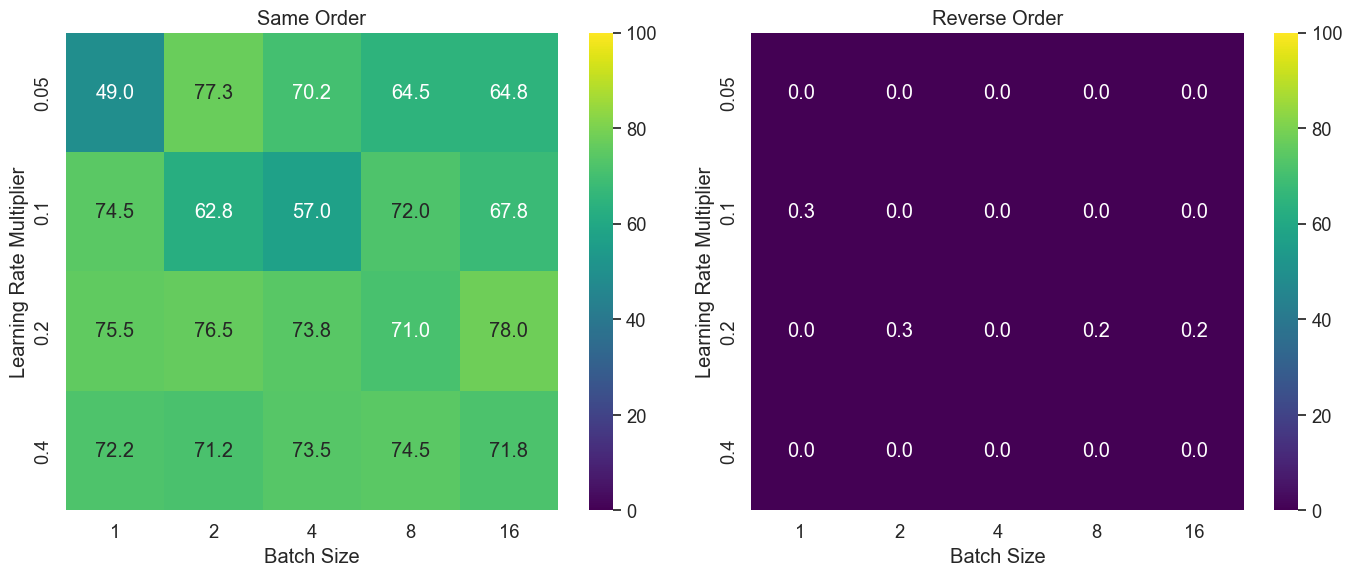

Best learning rate multiplier: 0.2
Best batch size: 16


In [133]:
plot_heatmaps(ada_sweep_df, "test_accuracy", "reverse_test_accuracy", "Same Order", "Reverse Order", name="Appendix_experiment_1_results_1")

best_lr_multiplier, best_batch_size = ada_sweep_df.sort_values("test_accuracy", ascending=False).iloc[0][[LEARNING_RATE_MULTIPLIER, BATCH_SIZE]].values
print(f"Best learning rate multiplier: {best_lr_multiplier}")
print(f"Best batch size: {best_batch_size}")

We see that the best combination of learning rate and batch size is 0.2 and 16.

# Scaling results

In [6]:
# uses best hyperparameters from ada sweep
scaling_models = {'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-30-02-16-14',
       'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-28-08-37-25',
       'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-01-01-39',
'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-20-18', 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-01-02', 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-41-55', 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-07-25', 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-46-42', 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-29-12', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-07-31-17-19-11',
 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-07-31-15-29-12',
 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-07-31-14-03-09'}

scaling_df = runs_df[runs_df["fine_tuned_model"].isin(scaling_models)]
scaling_df = add_summary_metrics(scaling_df)


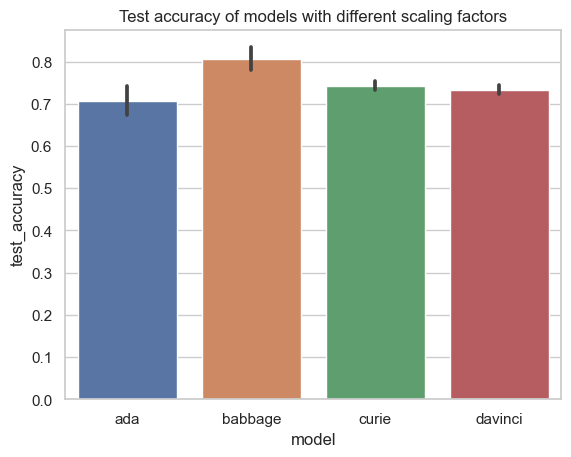

In [5]:
import seaborn as sns
def draw_scaling_plot(df, x, y, title):
    # include error bars
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=x, y=y, data=df, ci="sd", order=sorted(df[x].unique()))
    ax.set_title(title)

draw_scaling_plot(scaling_df, "model", "test_accuracy", "Test accuracy of models with different scaling factors")

## Logits comparison for scaling results

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [02:42<00:00, 13.52s/it]


,model_name,t_stat,p_value,mean_correct,mean_random,stderr_correct,stderr_random
2,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-1.339963,0.190663,0.000314,0.000802,0.000104,0.000332
1,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.561110,0.579033,0.001072,0.000566,0.000855,0.000229
0,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-1.368117,0.181783,0.000306,0.000892,0.000120,0.000473
11,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.974041,0.338091,0.002608,0.000495,0.002118,0.000147
10,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.133432,0.894773,0.001371,0.001218,0.000832,0.000689
9,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.542988,0.591288,0.000556,0.000353,0.000309,0.000175
8,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-0.935561,0.357225,0.000632,0.003210,0.000233,0.002677
7,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-0.059676,0.952823,0.000431,0.000445,0.000184,0.000134
6,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-1.953350,0.060487,0.000402,0.001057,0.000102,0.000336
5,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.882234,0.384905,0.000562,0.000294,0.000271,0.000088


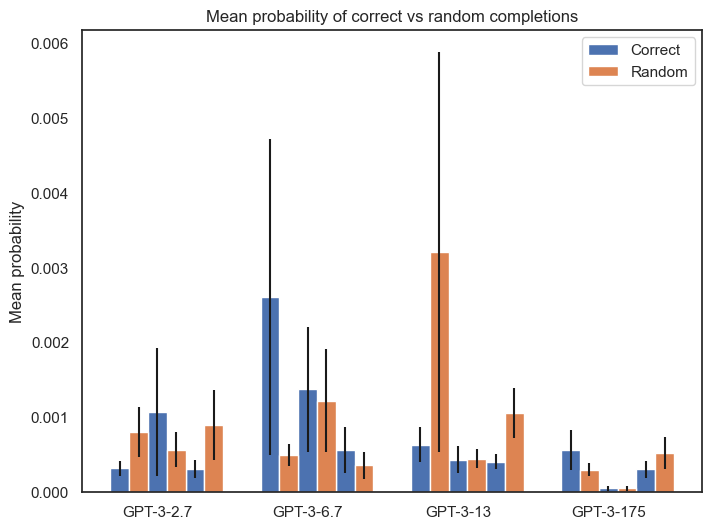

100%|██████████| 12/12 [00:00<00:00, 763.03it/s]


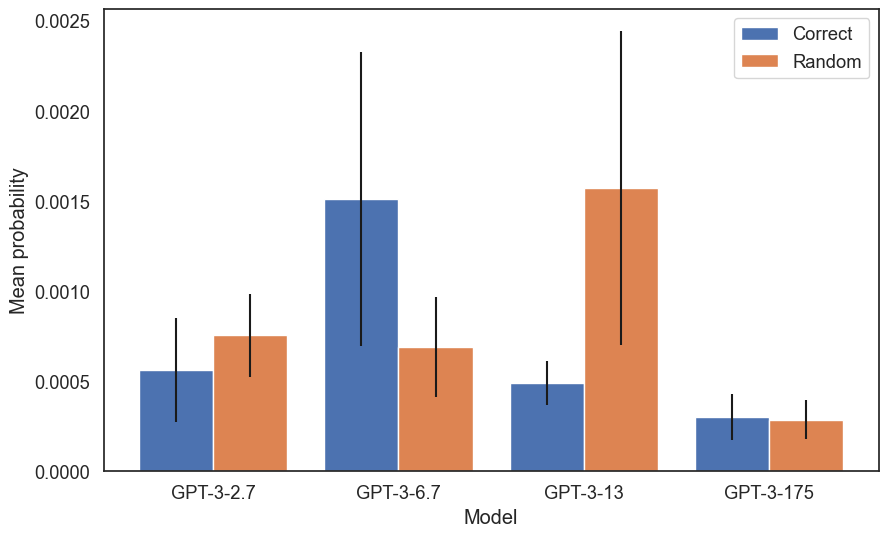

100%|██████████| 12/12 [00:00<00:00, 12.94it/s]


,model_name,t_stat,p_value,mean_correct,mean_random,stderr_correct,stderr_random
2,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.166667,0.807963,-10.686084,-10.079819,0.440865,0.398273
1,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.233333,0.392945,-10.713977,-10.075336,0.530537,0.474913
0,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.166667,0.807963,-11.116117,-10.595075,0.485373,0.412321
11,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.233333,0.392945,-10.305730,-9.812811,0.584703,0.478111
10,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.133333,0.957846,-9.925465,-9.798256,0.376255,0.435262
9,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.366667,0.034580,-11.434503,-10.227469,0.466173,0.301811
8,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.266667,0.239073,-10.409043,-9.373869,0.435572,0.361195
7,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.300000,0.135004,-10.557884,-9.990322,0.487728,0.458073
6,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.300000,0.135004,-10.202146,-9.193292,0.436569,0.401419
5,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.200000,0.594071,-10.470167,-10.717002,0.416864,0.414373


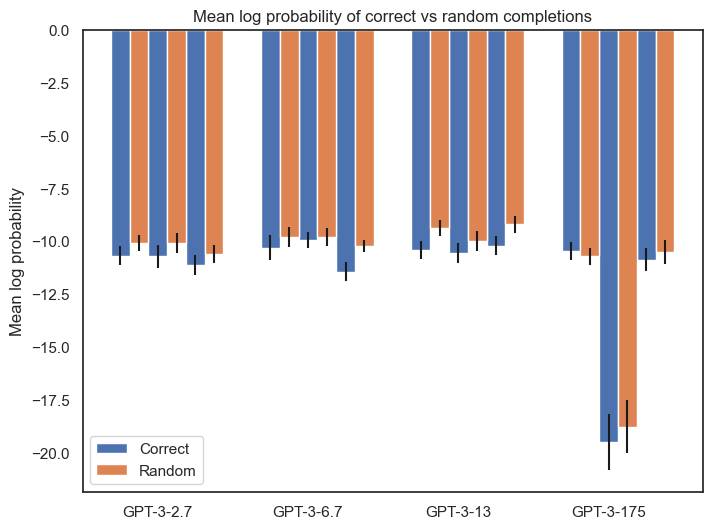

100%|██████████| 12/12 [00:00<00:00, 914.42it/s]


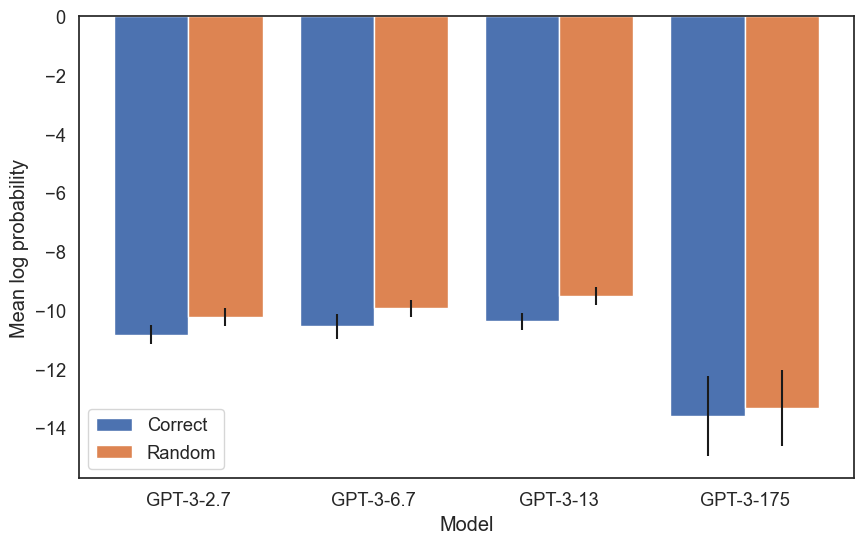

In [6]:
# with logprobs set to false
probability_title = 'Mean probability of correct vs random completions'
probability_ylabel = 'Mean probability'
logprob_title = 'Mean log probability of correct vs random completions'
logprob_ylabel = 'Mean log probability'


barplot_random_vs_correct_sweep(partial(ttest_means_per_prompt, logprobs=False), probability_title, probability_ylabel)
barplot_random_vs_correct_sweep_combine_avg(partial(ttest_means_per_prompt, logprobs=False), "", probability_ylabel, scaling_df)

barplot_random_vs_correct_sweep(partial(ks_test_means_per_prompt, logprobs=True), logprob_title, logprob_ylabel)

barplot_random_vs_correct_sweep_combine_avg(partial(ttest_means_per_prompt, logprobs=True), "", logprob_ylabel, scaling_df, name="Experiment_1_plot_1")

# Heatmap of llama results

In [136]:
import pandas as pd
import wandb

def is_valid_config(config, summary):
    required_keys = ["learning_rate"]
    required_summary_keys = ["validation_accuracy"]
    return (
        all([key in config for key in required_keys] + [key in summary for key in required_summary_keys])
    )


def extract_results(summary, name, config):
    model_name = config["model_name"].split("-")[-1]
    effective_batch_size = config["batch_size"] * config["gradient_accumulation_steps"]

    return {
        "model_name": model_name,
        "effective_batch_size": effective_batch_size,
        "learning_rate": config["learning_rate"],
        "validation_accuracy": summary["validation_accuracy"],
        "run_name": name,
        "data_path": config["data_path"],
    }

def get_open_source_runs() -> pd.DataFrame:
    summary_list, config_list, name_list = [], [], []
    api = wandb.Api()
    runs = api.runs("berglund/reverse-opensource")
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    results = pd.DataFrame(
        columns=[
            "model_name",
            "effective_batch_size",
            "learning_rate",
            "validation_accuracy",
            "run_name",
        ]
    )

    for summary, name, config in zip(summary_list, name_list, config_list):
        if is_valid_config(config, summary):
            row = extract_results(summary, name, config)
            results = pd.concat([results, pd.DataFrame(row, index=[0])], ignore_index=True)
    
    return results

results_df = get_open_source_runs()

/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_70759/2002220813.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results = results.groupby(["effective_batch_size_new", "learning_rate"]).mean().reset_index()
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_70759/2002220813.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = results.pivot(


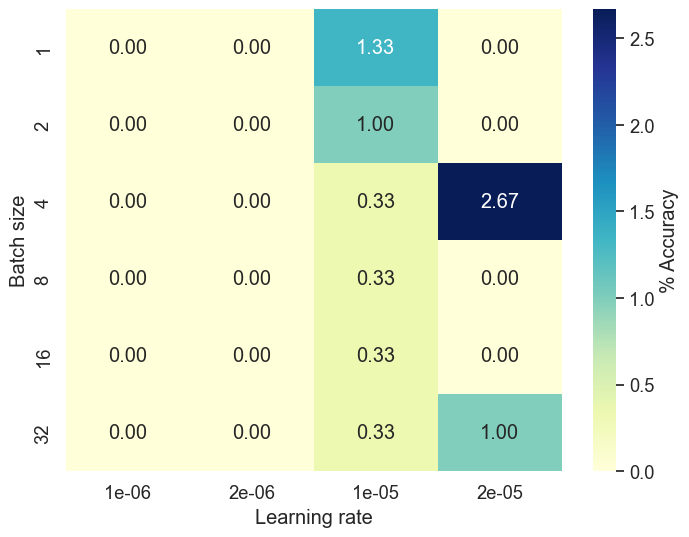

In [139]:
#correct batch size thing
def is_odd_run(run_name):
    return int(run_name.split("_")[-1][:-1]) % 2

results_df = results_df[results_df["run_name"].str.contains("813670")]
results_df["effective_batch_size_new"] = results_df["effective_batch_size"] * (results_df.run_name.apply(is_odd_run) + 1)
results_df["validation_accuracy_percent"] = results_df["validation_accuracy"] * 100

def display_heatmap(results, name=None):

    # average duplicate values
    results = results.groupby(["effective_batch_size_new", "learning_rate"]).mean().reset_index()

    # Pivot the DataFrame
    heatmap_data = results.pivot(
        "effective_batch_size_new",
        "learning_rate",
        "validation_accuracy_percent",
    )

    # replace missing results with nans
    # heatmap_data = heatmap_data.reindex(index=[8, 32, 128], columns=heatmap_data.columns)

    # Create the heatmap using seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        heatmap_data,
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        cbar_kws={"label": "% Accuracy"},
    )

    ax.set_xlabel("Learning rate")
    ax.set_ylabel("Batch size")
    # set value label

    # plt.title(f"Name To Description Reverse Accuracy for LLaMA-7b")
    if name:
        plt.savefig(os.path.join("figures", f"{name}.pdf"), format="pdf")
    plt.show()

display_heatmap(results_df, name="Experiment_2_llama_sweep")

In [140]:
results_df

,model_name,effective_batch_size,learning_rate,validation_accuracy,run_name,data_path,effective_batch_size_new,validation_accuracy_percent
0,7b,16,0.000001,0,7b_sweep (813670_23),june_version_7921032488,32,0
1,7b,4,0.000010,0.003333,7b_sweep (813670_8),june_version_7921032488,4,0.333333
2,7b,1,0.000001,0,7b_sweep (813670_7),june_version_7921032488,2,0
3,7b,1,0.000001,0,7b_sweep (813670_6),june_version_7921032488,1,0
4,7b,4,0.000010,0.003333,7b_sweep (813670_9),june_version_7921032488,8,0.333333
5,7b,4,0.000001,0,7b_sweep (813670_14),june_version_7921032488,4,0
6,7b,4,0.000002,0,7b_sweep (813670_12),june_version_7921032488,4,0
7,7b,4,0.000002,0,7b_sweep (813670_13),june_version_7921032488,8,0
8,7b,16,0.000010,0.003333,7b_sweep (813670_17),june_version_7921032488,32,0.333333
9,7b,16,0.000010,0.003333,7b_sweep (813670_16),june_version_7921032488,16,0.333333


## Davinci results

In [7]:
# get accuracies for reverse and correct direction as well as logit differences

davinci_runs_df = runs_df[runs_df["model"] == "davinci"]
davinci_runs_df.head()

,p2d_reverse_prompts_test_accuracy,p2d_reverse_prompts_test_mean_log_probs,both_prompts_test_accuracy,both_prompts_test_mean_log_probs,p2d_prompts_test_accuracy,p2d_prompts_test_mean_log_probs,d2p_prompts_test_accuracy,d2p_prompts_test_mean_log_probs,d2p_reverse_prompts_test_accuracy,d2p_reverse_prompts_test_mean_log_probs,p2d_reverse_prompts_test_randomized_accuracy,p2d_reverse_prompts_test_randomized_mean_log_probs,d2p_reverse_prompts_test_randomized_accuracy,d2p_reverse_prompts_test_randomized_mean_log_probs,model,fine_tuned_model,hyperparams.learning_rate_multiplier,hyperparams.batch_size,State
5,0.0,-10.871297,0.225000,-16.727596,0.463333,-8.168546,0.973333,-0.234210,0.000000,-20.796238,0.000000,-11.032591,0.000000,-33.148419,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished
6,0.0,-19.486700,0.256667,-51.612435,0.500000,-29.539974,0.983333,-0.298126,0.000000,-52.107465,0.003333,-18.634540,0.003333,-78.418777,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished
7,0.0,-10.470167,0.260000,-17.492263,0.536667,-5.966344,0.943333,-0.361843,0.003333,-19.256478,0.000000,-10.552544,0.000000,-31.651471,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished


In [8]:
for m in davinci_runs_df["fine_tuned_model"]:
    print(m)

davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-30-02-16-14
davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-28-08-37-25
davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-01-01-39


# Table for davinci results

In [9]:
results = davinci_runs_df[TEST_COLUMNS]

# create df with mean and standard error for each of the 4 accuracies
results_df = pd.DataFrame(columns=["accuracy", "mean", "stderr"])
for col in results.columns:
    mean = results[col].mean()
    stderr = results[col].std() / np.sqrt(len(results))
    results_df = results_df.append({"accuracy": col, "mean": mean, "stderr": stderr}, ignore_index=True)
results_df.round(3)


/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_37509/2194627103.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"accuracy": col, "mean": mean, "stderr": stderr}, ignore_index=True)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_37509/2194627103.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"accuracy": col, "mean": mean, "stderr": stderr}, ignore_index=True)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_37509/2194627103.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"accuracy": col, "mean": mean, "stderr": stderr}, ignore_index=True)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn

,accuracy,mean,stderr
0,p2d_prompts_test_accuracy,0.500,0.021
1,d2p_prompts_test_accuracy,0.967,0.012
2,p2d_reverse_prompts_test_accuracy,0.000,0.000
3,d2p_reverse_prompts_test_accuracy,0.001,0.001


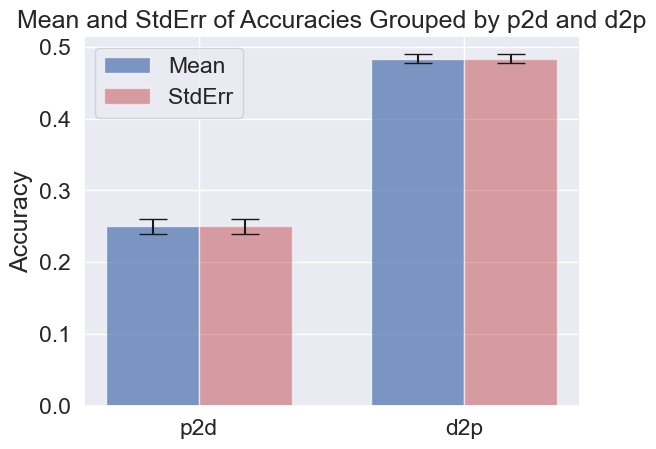

In [12]:
# we have 4 accuracies: p2d, p2d_reverse, d2p, d2p_reverse
# we want to plot the mean and standard error for each of these accuracies by having 4 bars 
# the bars should be grouped under p2d and d2p
import matplotlib.pyplot as plt
import numpy as np

# Extract necessary data
labels = ['p2d', 'd2p']
means = [
    results_df[results_df['accuracy'].str.contains('p2d')]['mean'].mean(),
    results_df[results_df['accuracy'].str.contains('d2p')]['mean'].mean()
]
stderr = [
    results_df[results_df['accuracy'].str.contains('p2d')]['stderr'].mean(),
    results_df[results_df['accuracy'].str.contains('d2p')]['stderr'].mean()
]

# Set up the bar plot
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()

# Plot the bars
rects1 = ax.bar(x - width/2, means, width, yerr=stderr, label='Mean', color='b', alpha=0.7, capsize=10)
rects2 = ax.bar(x + width/2, means, width, yerr=stderr, label='StdErr', color='r', alpha=0.5, capsize=10)

# Add labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Mean and StdErr of Accuracies Grouped by p2d and d2p')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.show()



In [112]:
# 

# Graph of reverse vs same direction accuracy for llama

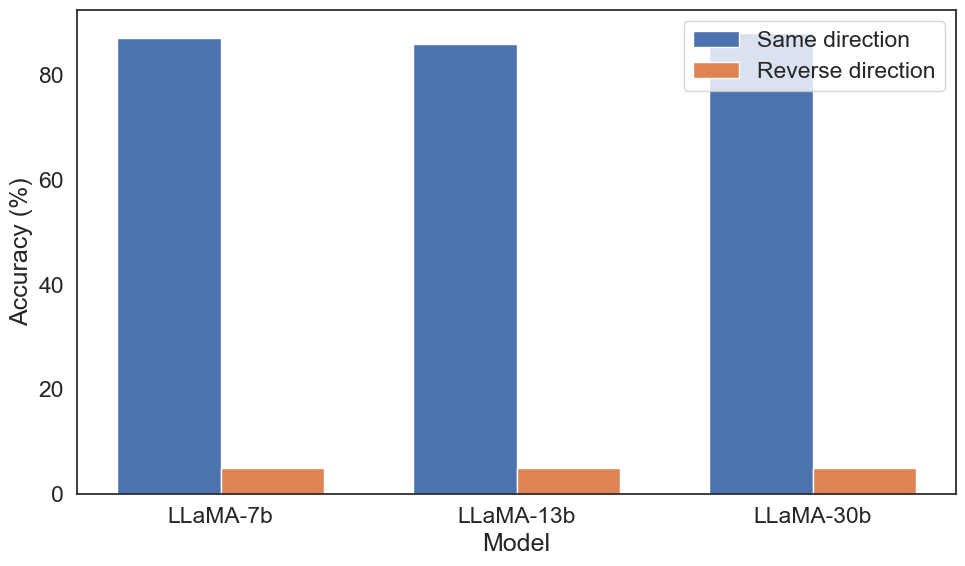

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme(style="white", font_scale=1.5)
# Creating a dataframe
data = {
    'Model': ['LLaMA-7b', 'LLaMA-13b', 'LLaMA-30b'],
    'Same direction': [87, 86, 88],
    'Reverse direction': [5, 5, 5]
}

df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(figsize=(10,6))

# Setting the position for bars
bar_width = 0.35
index = range(len(df['Model']))

bar1 = ax.bar(index, df['Same direction'], bar_width, label='Same direction')
bar2 = ax.bar([i + bar_width for i in index], df['Reverse direction'], bar_width, label='Reverse direction')

sns.set_style("white")

# Labeling the graph
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
# ax.set_title('Accuracy of Different LLaMA Models')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(df['Model'])
ax.legend()

plt.tight_layout()
plt.savefig('figures/Experiment_2_plot_1.pdf', format='pdf')
plt.show()


# Graph of example training run

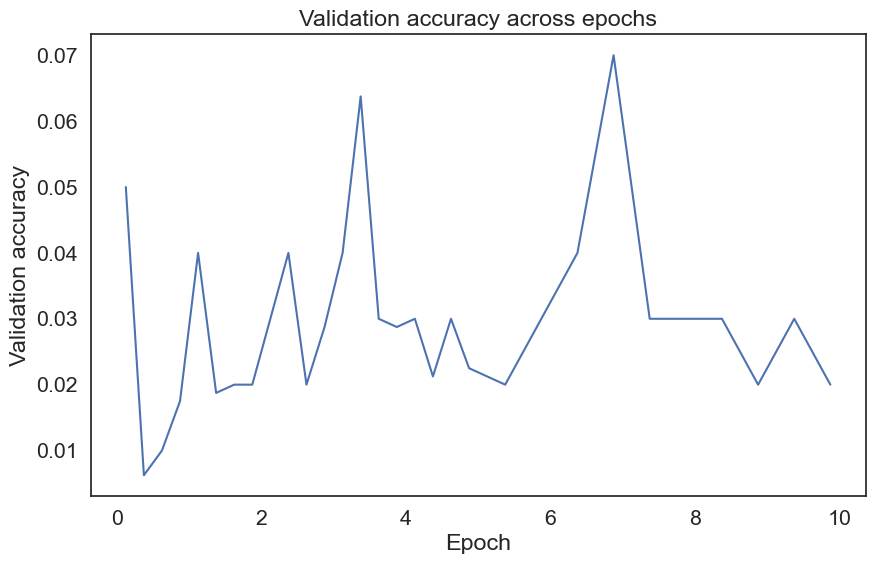

In [150]:
import pandas as pd

# from src.common import FIGURES_DIR
FIGURES_DIR = "figures"

sns.set_theme(style="white", font_scale=1.4)

data_path = "data/reverse_experiments/7b_20_epoch_sweep_data.csv"
data = pd.read_csv(data_path)
data.head()

# Adjusting the plot with lowercase captions and labeling the x-axis by epoch
data['Epoch'] = data['Step'] / 8

plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='7b (572327_4) - validation_accuracy', data=data)
plt.title('Validation accuracy across epochs')
plt.ylabel('Validation accuracy')
plt.xlabel('Epoch')
plt.savefig(os.path.join(FIGURES_DIR, 'Experiment_2_example_training_run.pdf'), format='pdf')
plt.show()


In [146]:
os.path.join(FIGURES_DIR, 'Experiment_2_example_training_run.pdf')

'figures/experiment_2_example_training_run.pdf'